# TM10007 Assignment template

In [65]:
# Run this to use from colab environment
#!pip install -q --upgrade git+https://github.com/jveenland/tm10007_ml.git

## Data loading and cleaning

Below are functions to load the dataset of your choice. After that, it is all up to you to create and evaluate a classification method. Beware, there may be missing values in these datasets. Good luck!

In [66]:
# Data loading functions. Uncomment the one you want to use
#from worcgist.load_data import load_data
#from worclipo.load_data import load_data
#from worcliver.load_data import load_data
#from ecg.load_data import load_data
# General packages
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn import datasets as ds
import seaborn as sns
import os

# Classifiers
from sklearn import model_selection
from sklearn.linear_model import LogisticRegression
from sklearn import metrics
from sklearn import feature_selection
from sklearn import preprocessing
from sklearn import neighbors
from sklearn import svm
from sklearn.feature_selection import VarianceThreshold
from sklearn.ensemble import RandomForestClassifier
from sklearn import decomposition
from sklearn.preprocessing import StandardScaler, RobustScaler, MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.svm import SVR

from scipy.signal import savgol_filter 
from scipy.stats import shapiro
from scipy.signal import find_peaks
from sklearn.ensemble import ExtraTreesClassifier
from lightgbm import LGBMClassifier



def load_data():
    this_directory = os.getcwd()
    data = pd.read_csv(os.path.join(this_directory, 'Lipo_radiomicFeatures_with_nans.csv'), index_col=0)
    return data

data = load_data()
print(f'The number of samples: {len(data.index)}')
print(f'The number of columns: {len(data.columns)}')

# Load the dataset
file_path = "data.csv"  # Ensure the dataset is in the same directory as the notebook
df = pd.read_csv(file_path)

# Display basic info and first few rows
df.info()
df.head()

The number of samples: 115
The number of columns: 494
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 115 entries, 0 to 114
Columns: 495 entries, ID to PREDICT_original_phasef_phasesym_entropy_WL3_N5
dtypes: float64(468), int64(25), object(2)
memory usage: 444.9+ KB


,ID,label,PREDICT_original_sf_compactness_avg_2.5D,PREDICT_original_sf_compactness_std_2.5D,PREDICT_original_sf_rad_dist_avg_2.5D,PREDICT_original_sf_rad_dist_std_2.5D,PREDICT_original_sf_roughness_avg_2.5D,PREDICT_original_sf_roughness_std_2.5D,PREDICT_original_sf_convexity_avg_2.5D,PREDICT_original_sf_convexity_std_2.5D,...,PREDICT_original_phasef_phasesym_median_WL3_N5,PREDICT_original_phasef_phasesym_std_WL3_N5,PREDICT_original_phasef_phasesym_skewness_WL3_N5,PREDICT_original_phasef_phasesym_kurtosis_WL3_N5,PREDICT_original_phasef_phasesym_peak_WL3_N5,PREDICT_original_phasef_phasesym_peak_position_WL3_N5,PREDICT_original_phasef_phasesym_range_WL3_N5,PREDICT_original_phasef_phasesym_energy_WL3_N5,PREDICT_original_phasef_phasesym_quartile_range_WL3_N5,PREDICT_original_phasef_phasesym_entropy_WL3_N5
0,Lipo-001_0,liposarcoma,0.368434,0.262371,26.200395,8.174390,20.940000,13.551937,0.694139,0.227848,...,0.049726,0.196019,0.927821,-0.407270,0.0,0,0.625304,3238.304991,0.315148,14.462361
1,Lipo-002_0,liposarcoma,0.660571,0.179013,55.155046,9.318741,9.546044,7.051937,0.871182,0.125279,...,0.036186,0.167471,1.137972,0.411968,0.0,0,0.563659,15364.724390,0.251255,17.170274
2,Lipo-003_0,lipoma,0.365191,0.157712,30.577026,8.963647,17.695139,10.772365,0.704710,0.137529,...,0.128167,0.220546,0.829650,-0.520344,0.0,0,0.705679,3771.798158,0.369366,14.394812
3,Lipo-004_0,liposarcoma,0.372210,0.169761,94.006805,33.512409,21.049148,15.928362,0.754497,0.186559,...,0.000000,0.107987,3.130011,10.399652,0.0,0,0.438399,4707.658397,0.000000,15.733482
4,Lipo-005_0,lipoma,0.369120,0.167485,94.612701,31.250821,17.059573,15.239905,0.774545,0.192922,...,0.000000,0.087662,3.284943,11.840826,0.0,0,0.356330,6171.440113,0.000000,16.682154


## Preprocessing
### Missing values & Clean-up

In [67]:
# Check for missing values and store them
missing_values = df[df.isna().any(axis=1)]

if not missing_values.empty:
    print("Missing values stored in missing_values")
else:
    print("No missing values found")

df = df.drop(missing_values.iloc[0:,:].index)

# Encode the target variable
df['label'] = df['label'].map({'lipoma': 0, 'liposarcoma': 1})

# Drop ID column as it is not useful for training
df.drop(columns=['ID'], inplace=True)

# Display dataset after preprocessing
df.head()

# Find ratio lipoma - liposarcoma
print(f"Sick-Healthy ratio: {df['label'].sum()}-{df.shape[0]-df['label'].sum()}")


No missing values found
Sick-Healthy ratio: 58-57


### Data distribution & Scaling

In [68]:
# Check Datadistribution & Scaling
outliers = 0
not_normal_dist = 0
scaler = preprocessing.MinMaxScaler()
for column in df.columns[1:]:
    column_data = df[column].values

    # Check for normal distribution
    statistic, pvalue = shapiro(column_data)
    if float(pvalue) > 0.05:
        not_normal_dist += 1

    # Check for outliers
    Q1 = np.percentile(column_data, 25)
    Q3 = np.percentile(column_data, 75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    outliers_count = np.sum((column_data < lower_bound) | (column_data > upper_bound))
    if outliers_count > 0:
        outliers += 1

    # Choose approprate scaler
    if not_normal_dist == 0 and outliers == 0:
        scaler = StandardScaler() 
    elif not_normal_dist != 0 and outliers == 0:
        scaler = MinMaxScaler() 
    else:
        scaler = RobustScaler()

df_label0 = df[df['label']==0]
not_normal_dist0 = 0
for column in df.columns[1:]:
    column_data = df_label0[column].values

    # Check for normal distribution
    statistic, pvalue = shapiro(column_data)
    if float(pvalue) > 0.05:
        not_normal_dist0 += 1

df_label1 = df[df['label']==1]
not_normal_dist1 = 0
for column in df.columns[1:]:
    column_data = df_label1[column].values

    # Check for normal distribution
    statistic, pvalue = shapiro(column_data)
    if float(pvalue) > 0.05:
        not_normal_dist1 += 1

df.iloc[:, 1:] = scaler.fit_transform(df.iloc[:, 1:])

print(f"Scaler used: {scaler}")
print(f"Ratio of Gaussian/NonGaussian distributions in all data: {not_normal_dist} - {df.shape[1]-not_normal_dist}")
print(f"Ratio of NoOutliers/Outliers in features in all data: {df.shape[1]-outliers} - {outliers}")

print(f"Ratio of Gaussian/NonGaussian feature distribution in healthy data: {not_normal_dist0} - {df_label0.shape[1]-not_normal_dist0}")
print(f"Ratio of Gaussian/NonGaussian feature distribution in sick data: {not_normal_dist1} - {df_label1.shape[1]-not_normal_dist1}")


Scaler used: RobustScaler()
Ratio of Gaussian/NonGaussian distributions in all data: 66 - 428
Ratio of NoOutliers/Outliers in features in all data: 57 - 437
Ratio of Gaussian/NonGaussian feature distribution in healthy data: 117 - 377
Ratio of Gaussian/NonGaussian feature distribution in sick data: 86 - 408


/Applications/miniconda3/lib/python3.12/site-packages/scipy/stats/_axis_nan_policy.py:586: UserWarning: scipy.stats.shapiro: Input data has range zero. The results may not be accurate.
  res = hypotest_fun_out(*samples, **kwds)
/var/folders/7c/k7s45g950s74y_jl8zgdy5hh0000gn/T/ipykernel_57121/2509858114.py:51: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[-0.59259259  0.07407407  0.66666667 -1.25925926  0.37037037 -0.74074074
  0.51851852 -0.07407407 -0.66666667 -0.14814815  0.14814815  0.59259259
  0.66666667  0.44444444  0.44444444 -1.11111111 -0.51851852 -0.14814815
  0.37037037 -0.44444444  0.51851852  0.2962963   0.51851852  0.22222222
  0.2962963   0.2962963  -0.2962963   0.22222222 -0.37037037 -1.48148148
  0.59259259 -0.59259259  0.22222222 -1.55555556 -2.         -0.37037037
  0.44444444  0.37037037 -0.07407407  0.37037037 -0.66666667  0.
 -1.7037037  -0.14814815  0.44444444  0.          0.37037037 -1.1111

### Data split

In [69]:
# Split into train and test
X = df
y = df.iloc[:, 0]
X_train, X_test, y_train, y_test = model_selection.train_test_split(X, y, test_size=0.2, stratify=y)
print(f'The number of samples in train data: {(X_train.shape[0])}')
print(f'The number of samples in test data: {(X_test.shape[0])}')

The number of samples in train data: 92
The number of samples in test data: 23


### Feature Selection
#### Variance

In [70]:
# Feature selection based on variance
variance_selector = VarianceThreshold(threshold=0.01)
data_var= variance_selector.fit_transform(X_train.iloc[:, 1:])

print(f"Features reduced from {X_train.shape[1]} to {data_var.shape[1]} features after variation filtering")

Features reduced from 494 to 467 features after variation filtering


In [71]:
# # Apply PCA based on them to explain 99% of the data
# pca = decomposition.PCA(n_components= 0.9999999999999999)
# data_pca = pca.fit_transform(data_var)

# print(f'The number of columns after variance selection: {(data_pca.shape[1])}')
# print(f'The number of rows after variance selection: {(data_pca.shape[0])}')

#### Correlation 


In [72]:
# Removing redundant features based on correlation
data_var_df = pd.DataFrame(data_var)
corr_matrix = data_var_df.corr().abs()  # Get absolute correlation matrix
upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(bool))

# Drop features with correlation higher than 0.9
to_drop = [column for column in upper.columns if any(upper[column] > 0.8)]
data_cor = data_var_df.drop(columns=to_drop)

print(f"Features reduced from {data_var.shape[1]} to {data_cor.shape[1]} features after correlation filtering")


Features reduced from 467 to 112 features after correlation filtering


#### RFE: linear

/Applications/miniconda3/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/Applications/miniconda3/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logisti

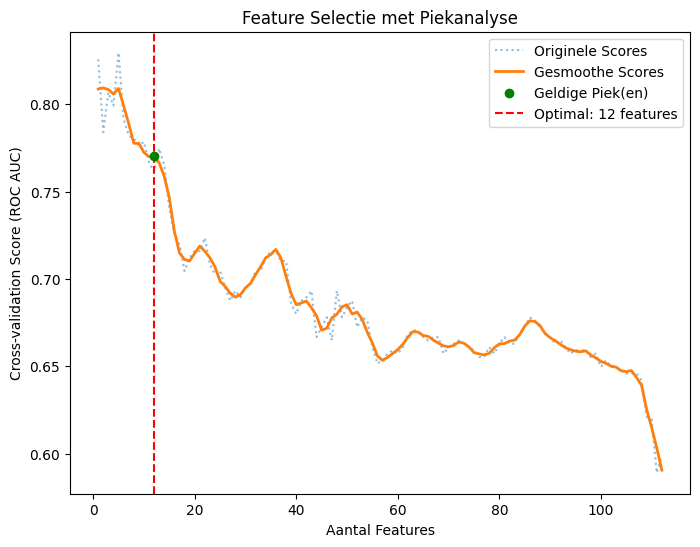

Optimale aantal features gekozen: 12


In [73]:
# Linear feature selection by RFE
est_lin = LogisticRegression(max_iter=500)

# classifications
rfecv = feature_selection.RFECV(
    estimator = est_lin, step=1,
    cv=model_selection.StratifiedKFold(4),
    scoring='roc_auc')
rfecv.fit(data_cor, y_train)

# Haal de CV-scores op
cv_scores = rfecv.cv_results_["mean_test_score"]
num_features = np.arange(1, len(cv_scores) + 1)

# Smooth de scores met Savitzky-Golay
smoothed_scores = savgol_filter(cv_scores, window_length=7, polyorder=2)  # Pas window_length aan als nodig

# Zoek pieken in de gesmoothe curve
peaks, properties = find_peaks(smoothed_scores, height=None)  # Zoekt alle pieken

# Bepaal de maximale score en de 5%-drempel
max_score = np.max(smoothed_scores)
threshold = max_score * 0.95  # 95% van de maximale score

# Filter pieken die:
# 1. Minimaal 10 features hebben
# 2. Binnen de 5% marge van de max-score zitten
valid_peaks = [p for p in peaks if num_features[p] >= 10 and smoothed_scores[p] >= threshold]

# Selecteer de eerste geschikte piek
optimal_index = valid_peaks[0] if valid_peaks else np.argmax(smoothed_scores)
optimal_features_lin = num_features[optimal_index]

# Plot de originele en gesmoothe scores
plt.figure(figsize=(8, 6))
plt.plot(num_features, cv_scores, label="Originele Scores", alpha=0.5, linestyle="dotted")
plt.plot(num_features, smoothed_scores, label="Gesmoothe Scores", linewidth=2)
plt.scatter(num_features[valid_peaks], smoothed_scores[valid_peaks], color='g', label="Geldige Piek(en)", zorder=3)
plt.axvline(optimal_features_lin, color='r', linestyle="--", label=f"Optimal: {optimal_features_lin} features")
plt.xlabel("Aantal Features")
plt.ylabel("Cross-validation Score (ROC AUC)")
plt.legend()
plt.title("Feature Selectie met Piekanalyse")
plt.show()

print(f"Optimale aantal features gekozen: {optimal_features_lin}")


#### RFE: non-linear


/Applications/miniconda3/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/Applications/miniconda3/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/Applications/miniconda3/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/Applications/miniconda3/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/Applications/miniconda3/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature nam

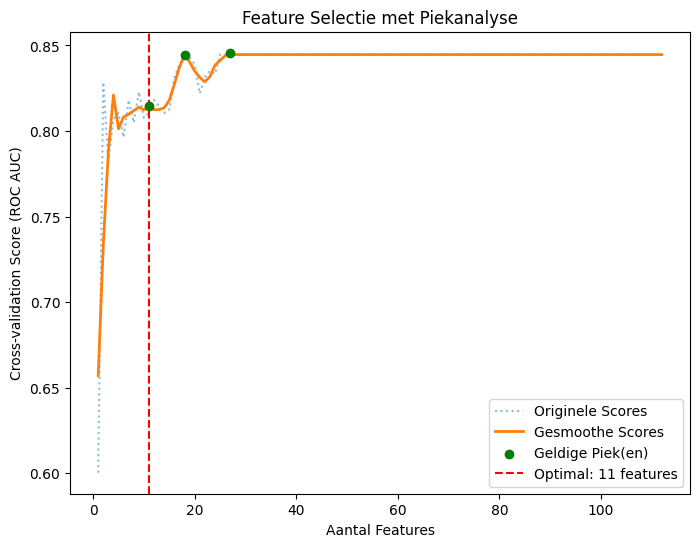

Optimale aantal features gekozen: 11


In [74]:
# Feature selection by RFE
est_nl = LGBMClassifier(n_estimators=50, learning_rate=0.1, random_state=42, verbose=-1)

# classifications
rfecv = feature_selection.RFECV(
    estimator = est_nl, step=1,
    cv=model_selection.StratifiedKFold(4),
    scoring='roc_auc')
rfecv.fit(data_cor, y_train)

# Haal de CV-scores op
cv_scores = rfecv.cv_results_["mean_test_score"]
num_features = np.arange(1, len(cv_scores) + 1)

# Smooth de scores met Savitzky-Golay
smoothed_scores = savgol_filter(cv_scores, window_length=7, polyorder=2)  # Pas window_length aan als nodig

# Zoek pieken in de gesmoothe curve
peaks, properties = find_peaks(smoothed_scores, height=None)  # Zoekt alle pieken

# Bepaal de maximale score en de 5%-drempel
max_score = np.max(smoothed_scores)
threshold = max_score * 0.95  # 95% van de maximale score

# Filter pieken die:
# 1. Minimaal 10 features hebben
# 2. Binnen de 5% marge van de max-score zitten
valid_peaks = [p for p in peaks if num_features[p] >= 10 and smoothed_scores[p] >= threshold]

# Selecteer de eerste geschikte piek
optimal_index = valid_peaks[0] if valid_peaks else np.argmax(smoothed_scores)
optimal_features_nl = num_features[optimal_index]

# Plot de originele en gesmoothe scores
plt.figure(figsize=(8, 6))
plt.plot(num_features, cv_scores, label="Originele Scores", alpha=0.5, linestyle="dotted")
plt.plot(num_features, smoothed_scores, label="Gesmoothe Scores", linewidth=2)
plt.scatter(num_features[valid_peaks], smoothed_scores[valid_peaks], color='g', label="Geldige Piek(en)", zorder=3)
plt.axvline(optimal_features_nl, color='r', linestyle="--", label=f"Optimal: {optimal_features_nl} features")
plt.xlabel("Aantal Features")
plt.ylabel("Cross-validation Score (ROC AUC)")
plt.legend()
plt.title("Feature Selectie met Piekanalyse")
plt.show()

print(f"Optimale aantal features gekozen: {optimal_features_nl}")

#### Final feature selections

In [75]:
# Linear feature selection with Logistic Regression
logreg = LogisticRegression(random_state=42, max_iter=1000)
logreg.fit(X_train, y_train)

feature_importance = np.abs(logreg.coef_[0])

n_importance = optimal_features_lin
important_features_lin = sorted(range(len(feature_importance)), key=lambda i: feature_importance[i], reverse=True)[:n_importance]

print(f"Most important features (indices), linear: {important_features_lin}")
print(f"Feature importances (coefficients): {feature_importance[important_features_lin]}")

# Nonlinear feature selection with Random Forest
randomforest =  RandomForestClassifier(n_estimators = 100, random_state=42)
randomforest.fit(X_train, y_train)

feature_importance = randomforest.feature_importances_

n_importance = optimal_features_nl
important_features_nl = sorted(range(len(feature_importance)), key=lambda i: feature_importance[i], reverse=True)[:n_importance]

print(f"Most important features (indices), non-linear: {important_features_nl}")
print(f"Feature importances: {feature_importance[important_features_nl]}")

# Combining important linear and non-linear features
combined_important_features = list(set(important_features_lin) | set(important_features_nl))
print(f"Combined important features (indices): {combined_important_features}")
print(f"Features reduced from {data_cor.shape[1]} to {len(combined_important_features)} features after correlation filtering")


Most important features (indices), linear: [444, 87, 427, 440, 446, 448, 85, 280, 267, 93, 335, 443]
Feature importances (coefficients): [0.07325615 0.03436309 0.02394308 0.02394308 0.02108461 0.01810091
 0.01550505 0.00998059 0.0093709  0.0085779  0.00805698 0.00783069]
Most important features (indices), non-linear: [0, 21, 314, 20, 379, 71, 258, 327, 67, 487, 12]
Feature importances: [0.10557171 0.03533429 0.02190095 0.01755795 0.00947951 0.00933804
 0.00886787 0.00873177 0.00846884 0.00811285 0.00810689]
Combined important features (indices): [448, 0, 258, 67, 71, 327, 267, 12, 335, 20, 85, 21, 87, 280, 93, 487, 427, 379, 440, 314, 443, 444, 446]
Features reduced from 112 to 23 features after correlation filtering


/Applications/miniconda3/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


In [ ]:
# Check for missing values in test data
missing_values = missing_values.dropna(subset=combined_important_features)
print(missing_values)
y_missing = missing_values.loc[X_test.index]

Empty DataFrame
Columns: [ID, label, PREDICT_original_sf_compactness_avg_2.5D, PREDICT_original_sf_compactness_std_2.5D, PREDICT_original_sf_rad_dist_avg_2.5D, PREDICT_original_sf_rad_dist_std_2.5D, PREDICT_original_sf_roughness_avg_2.5D, PREDICT_original_sf_roughness_std_2.5D, PREDICT_original_sf_convexity_avg_2.5D, PREDICT_original_sf_convexity_std_2.5D, PREDICT_original_sf_cvar_avg_2.5D, PREDICT_original_sf_cvar_std_2.5D, PREDICT_original_sf_prax_avg_2.5D, PREDICT_original_sf_prax_std_2.5D, PREDICT_original_sf_evar_avg_2.5D, PREDICT_original_sf_evar_std_2.5D, PREDICT_original_sf_solidity_avg_2.5D, PREDICT_original_sf_solidity_std_2.5D, PREDICT_original_sf_area_avg_2.5D, PREDICT_original_sf_area_max_2.5D, PREDICT_original_sf_area_min_2.5D, PREDICT_original_sf_area_std_2.5D, PREDICT_original_sf_volume_2.5D, PREDICT_original_of_theta_x, PREDICT_original_of_theta_y, PREDICT_original_of_theta_z, PREDICT_original_hf_min, PREDICT_original_hf_max, PREDICT_original_hf_mean, PREDICT_original_

KeyError: "None of [Index([ 78,  68,  71,  18,  25,   7,  44,   9,   6,  29, 113,  56,  32,  19,\n        70,   1,  93,  50,  91,  36,  58,  77,  37],\n      dtype='int64')] are in the [index]"

#### Classifiers

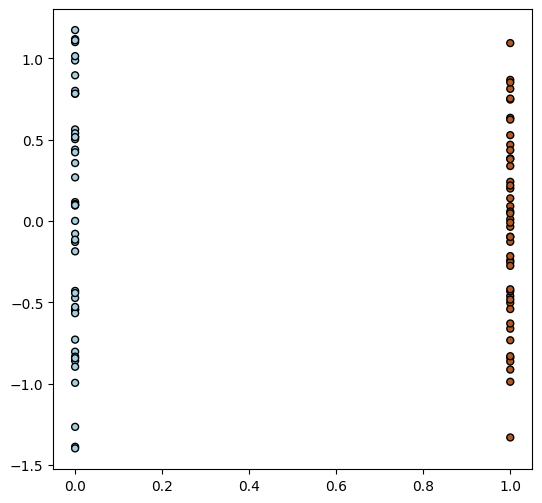

In [ ]:
# # Linear --> LinearDiscriminantAnalysis
# Quadratic --> QuadraticDiscriminantAnalysis
# K-nearest neighbours --> KNeighborsClassifier
# Gaussian --> GuassianNB
# Logistic Regression --> LogisticRegression
# Stochastic Gradient Descent --> SGDClassifier
# Random Forest --> RandomForestClassifier
# SVM --> 
# Kernel trick

# Classifiers
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import SGDClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn import svm 

def colorplot(clf, ax, x, y, h=100, precomputer=None):
    '''
    Overlay the decision areas as colors in an axes.

    Input:
        clf: trained classifier
        ax: axis to overlay color mesh on
        x: feature on x-axis
        y: feature on y-axis
        h(optional): steps in the mesh
    '''
    # Create a meshgrid the size of the axis
    xstep = (x.max() - x.min() ) / 20.0
    ystep = (y.max() - y.min() ) / 20.0
    x_min, x_max = x.min() - xstep, x.max() + xstep
    y_min, y_max = y.min() - ystep, y.max() + ystep
    h = max((x_max - x_min, y_max - y_min))/h
    xx, yy = np.meshgrid(np.arange(x_min, x_max, h),
                         np.arange(y_min, y_max, h))

    # features = np.c_[xx.ravel(), yy.ravel()]
    # if precomputer is not None:
    #     if type(precomputer) is RBFSampler:
    #         features = precomputer.transform(features)
    #     elif precomputer is rbf_kernel:
    #         features = rbf_kernel(features, X)

    # Plot the decision boundary. For that, we will assign a color to each
    # point in the mesh [x_min, x_max]x[y_min, y_max].
    if hasattr(clf, "decision_function"):
        Z = clf.decision_function(combined_important_features)
    else:
        Z = clf.predict_proba(combined_important_features)
    if len(Z.shape) > 1:
        Z = Z[:, 1]

    print(Z) 

    # Put the result into a color plot
    cm = plt.cm.RdBu_r
    Z = Z.reshape(xx.shape)
    ax.contourf(xx, yy, Z, cmap=cm, alpha=.8)
    del xx, yy, x_min, x_max, y_min, y_max, Z, cm


clsfs = [LinearDiscriminantAnalysis(),QuadraticDiscriminantAnalysis(),KNeighborsClassifier(),GaussianNB(),
         LogisticRegression(),SGDClassifier(),DecisionTreeClassifier()]
Xs = [X_train]
Ys = [y_train]
clfs_fit = list()

# First make a plot without classifiers:
fig = plt.figure(figsize=(21,7*len(clsfs)))
num = 0  # Iteration number for the subplots
for X, Y in zip(Xs, Ys):
    ax = fig.add_subplot(7, 3, num + 1)
    ax.scatter(X.iloc[:,0], X.iloc[:,1], c=Y, marker='o', 
               s=25, edgecolor='k', cmap=plt.cm.Paired)
    num += 1




# Fit the classifiers and add them to the plot
# num=0
# Xt=list()
# Yt=list()
# for clf in clsfs:
#     for X, Y in zip(Xs, Ys):
#         # Fit classifier
#         clf.fit(X,Y)
#         y_pred=clf.predict(X)
#         # Predict labels using fitted classifier

#         # Make scatterplot of features
#         ax = fig.add_subplot(7, 3, num + 1)
#         ax.scatter(X.iloc[:,0], X.iloc[:,1], c=Y, marker='o',
#                s=25, edgecolor='k', cmap=plt.cm.Paired)
#         colorplot(clf, ax, X.iloc[:,0], X.iloc[:,1])
#         # Add overlay through colorplot function
#         t=("Misclass: %d / %d" % ((Y!=y_pred).sum(), X.shape[0]))
#         ax.set_title(t)
#         num+=1

#         clfs_fit.append(clf)
#         Xt.append(X)
#         Yt.append(Y)

